In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

Open    High     Low    Last  Change  Settle  Volume  \
Date                                                                 
1976-08-02  3398.0  3401.0  3398.0  3401.0     NaN  3401.0     2.0   
1976-08-03  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-04  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-05  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-06  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   

            Previous Day Open Interest  
Date                                    
1976-08-02                         1.0  
1976-08-03                         1.0  
1976-08-04                         1.0  
1976-08-05                         1.0  
1976-08-06                         1.0

In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

Open    High     Low    Last  Change  Settle   Volume  \
Date                                                                  
1990-01-02  6954.0  6954.0  6835.0  6847.0     NaN  6847.0  48336.0   
1990-01-03  6877.0  6910.0  6865.0  6887.0     NaN  6887.0  38206.0   
1990-01-04  6937.0  7030.0  6924.0  7008.0     NaN  7008.0  49649.0   
1990-01-05  6952.0  6985.0  6942.0  6950.0     NaN  6950.0  29944.0   
1990-01-08  6936.0  6972.0  6936.0  6959.0     NaN  6959.0  19763.0   

            Previous Day Open Interest  
Date                                    
1990-01-02                     51473.0  
1990-01-03                     53860.0  
1990-01-04                     55699.0  
1990-01-05                     53111.0  
1990-01-08                     52072.0

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

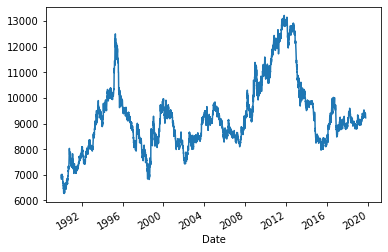

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yf_noise, yf_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yf_combined = pd.concat([yen_futures['Settle'], yf_noise, yf_trend], axis='columns')
yf_combined.head()

Settle  Settle_cycle  Settle_trend
Date                                          
1990-01-02  6847.0    -61.503967   6908.503967
1990-01-03  6887.0    -21.799756   6908.799756
1990-01-04  7008.0     98.942896   6909.057104
1990-01-05  6950.0     40.776052   6909.223948
1990-01-08  6959.0     49.689938   6909.310062

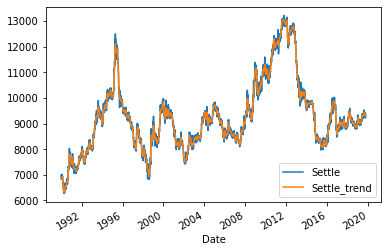

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yf_combined_plot = yf_combined.plot(y=['Settle', 'Settle_trend'])

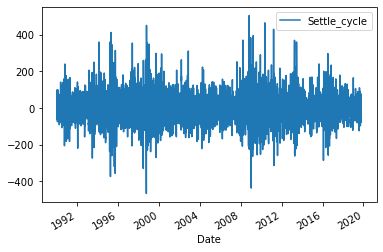

In [8]:
# Plot the Settle Noise
yf_noise_plot = yf_combined.plot(y="Settle_cycle")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Settle
Date                
2019-10-09 -0.410601
2019-10-10 -0.369458
2019-10-11 -0.564304
2019-10-14  0.151335
2019-10-15 -0.469509

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
yen_ARMA_model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
yen_ARMA_results = yen_ARMA_model.fit()

C:\Users\jalex\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [11]:
# Output model summary results:
yen_ARMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 31 Mar 2021   AIC                          15798.142
Time:                        19:35:30   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2096           +0.0000j          157.2096            0.5000
MA.1           -3.3941           +0.0000j            3.3941            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Yen Returns Forecast'}>

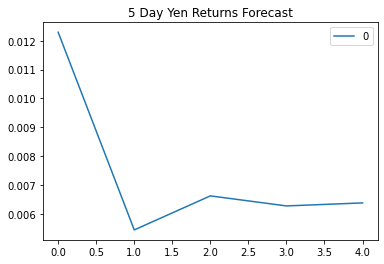

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(yen_ARMA_results.forecast(steps=5)[0]).plot(title="5 Day Yen Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
yen_ARIMA_model = ARIMA(returns, order=(5, 1, 1))

# Fit the model
yen_ARIMA_results = yen_ARIMA_model.fit()

C:\Users\jalex\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jalex\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jalex\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
yen_ARIMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.994
Date:                Wed, 31 Mar 2021   AIC                          15805.989
Time:                        19:35:44   BIC                          15854.460
Sample:                             0   HQIC                         15822.632
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0117      0.008     -1.407      0.160      -0.028       0.005
ar.L2         -0.0005      0.009     -0.060      0.953      -0.018       0.017
ar.L3         -0.0129      0.010     -1.356      0.175      -0.032       0.006
ar.L4         -0.0192      0.010     -1.954      0.051      -0.039    5.71e-05
ar.L5         -0.0021      0.010     -0.218      0.828      -0.021       0.017
ma.L1         -1.0000      0.029    -34.344      0.000      -1.057      -0.943
sigma2         0.4786      0.015     32.031      0.000       0.449       0.508
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17150.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\jalex\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:title={'center':'5 Day Yen Returns Forecast'}>

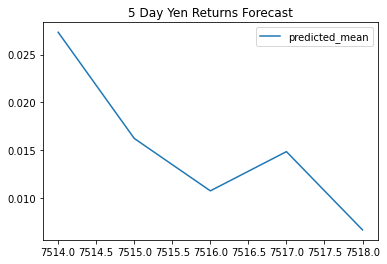

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(yen_ARIMA_results.forecast(steps=5)).plot(title="5 Day Yen Returns Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
from arch import arch_model

In [19]:
# Estimate a GARCH model:
yen_GARCH_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
yen_GARCH_results = yen_GARCH_model.fit(disp="off")

In [20]:
# Summarize the model results
yen_GARCH_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Wed, Mar 31 2021   Df Residuals:                     7514
Time:                        19:36:28   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [24]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
yen_GARCH_forecasts = yen_GARCH_results.forecast(start='2009-12-31', horizon=forecast_horizon)

In [25]:
# Annualize the forecast
intermediate = np.sqrt(yen_GARCH_forecasts.variance.dropna() * 252)
intermediate.head()

h.1        h.2        h.3        h.4        h.5
Date                                                             
2009-12-31  12.285970  12.278909  12.271902  12.264950  12.258052
2010-01-04  12.183226  12.176963  12.170749  12.164583  12.158466
2010-01-05  12.275336  12.268357  12.261432  12.254561  12.247743
2010-01-06  12.234613  12.227950  12.221339  12.214779  12.208270
2010-01-07  12.236807  12.230127  12.223499  12.216922  12.210397

In [26]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date  2009-12-31  2010-01-04  2010-01-05  2010-01-06  2010-01-07  2010-01-08  \
h.1    12.285970   12.183226   12.275336   12.234613   12.236807   12.123089   
h.2    12.278909   12.176963   12.268357   12.227950   12.230127   12.117297   
h.3    12.271902   12.170749   12.261432   12.221339   12.223499   12.111549   
h.4    12.264950   12.164583   12.254561   12.214779   12.216922   12.105847   
h.5    12.258052   12.158466   12.247743   12.208270   12.210397   12.100190   

Date  2010-01-11  2010-01-12  2010-01-13  2010-01-14  ...  2019-10-02  \
h.1    12.020683   12.328380   12.172375   12.033275  ...    7.601849   
h.2    12.015696   12.320991   12.166196   12.028188  ...    7.641259   
h.3    12.010748   12.313659   12.160066   12.023142  ...    7.680141   
h.4    12.005840   12.306384   12.153984   12.018136  ...    7.718507   
h.5    12.000970   12.299165   12.147950   12.013169  ...    7.756366   

Date  2019-10-03  2019-10-04  2019-10-07  2019-10-08  2019-10-09  2019-10-10  \
h.1     7.537719    7.434147    7.445512    7.363772    7.376203    7.367164   
h.2     7.577994    7.475842    7.487050    7.406448    7.418705    7.409793   
h.3     7.617725    7.516963    7.528017    7.448528    7.460615    7.451826   
h.4     7.656922    7.557521    7.568425    7.490024    7.501945    7.493278   
h.5     7.695596    7.597528    7.608284    7.530950    7.542708    7.534159   

Date  2019-10-11  2019-10-14  2019-10-15  
h.1     7.476237    7.389298    7.434048  
h.2     7.517352    7.431617    7.475745  
h.3     7.557905    7.473348    7.516867  
h.4     7.597907    7.514502    7.557426  
h.5     7.637369    7.555094    7.597434  

[5 rows x 2467 columns]

<AxesSubplot:>

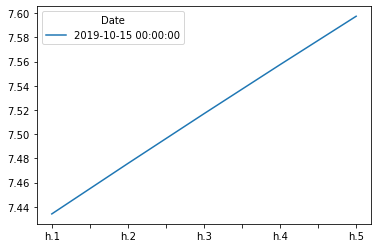

In [36]:
# Plot the final forecast
final.plot(y=[last_day])

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

### ANSWER
---
Based on the analysis, I would not by yen now.  Per the ARMA and ARIMA, yen should trend down in the short term.  Additionally, volatility seems to be trending upwards, making yen more risky.

However, due to the high P values of the ARMA and ARIMA lags, I would not feel comfortable using these for trading as they don't seem to be as predictive as I'd want for putting money out there.